# Project Report: Predicting Zestimate Logerror Using Clustering
## By Gabriela Tijerina & Justin Sullivan
### April 7, 2021

---

## Project Summary

> **Project Goal:**<br>
> Can we build a predictive model for logerror that would improve upon the baseline model's performance?

> **Project Approach:**<br>
> Will the use of Clustering Algorithms assist with selecting the best features for predicting logerror? 

> **Summary:**
> - Drivers of logerror:
    - Bathroomcnt, Bedroomcnt, and Linving Area Square Feet are the top drivers of logerror
    - Engineered features such as property acres by living square feet may help with improving models in future iterations
    - County is a feature of logerror where LA County has statistically greater logerrors than Orange/Ventura County
    
> - Modeling:
    - Linear Regression models, controlling for county, did not improve upon their respective baseline performances
    - Models controlling for county did generally improve upon models without controlling for county, however.


---

# Data Wrangling

In [1]:
#imports

#python libraries and tools 
import pandas as pd
import numpy as np

#import stats and testing
from scipy import stats

#Modules we created 
import acquire
import prepare
import explore
import evaluate
from env import host, user, password

#Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn Tools and Modules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures

#formatting tools
from tabulate import tabulate
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
sns.color_palette("colorblind")

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Step 1: Data Acquisition<br>
> The Zillow Data was obtained from the CodeUp SQL Server Database:<br>
        > - Data includes single unit properties that were last sold in 2017<br>
        > - The properties are located within three counties in Southern California (Los Angeles, Ventura, Orange)


In [2]:
#Acquire Data using acquire module and get_zillow_data function
df = acquire.get_zillow_data(cached=True)

#Preview the shape of the acquired dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       77413 │          67 │
╘══════════════════╧═════════════╧═════════════╛


---

### Step 2: Data Preparation

***A) Preview the Dataframe***

In [3]:
df.head(2)

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,NaN,NaN,2.0,NaN,NaN,NaN,10711855,1087254,NaN,2.0,3.0,8.0,2.0,NaN,NaN,2107.0,2107.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,34222559.0,-118617387.0,9158.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE9,6.037113e+07,12447.0,3101.0,268588.0,96339.0,0.0,NaN,1.0,NaN,NaN,1972.0,NaN,NaN,249655.0,624139.0,2016.0,374484.0,7659.36,NaN,NaN,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,NaN,NaN
1,NaN,NaN,2.0,NaN,NaN,1.0,10711877,1072280,NaN,2.0,4.0,8.0,2.0,NaN,NaN,1882.0,1882.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,34220261.0,-118616409.0,9035.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE9,6.037113e+07,12447.0,3101.0,268588.0,96339.0,0.0,NaN,1.0,NaN,NaN,1972.0,NaN,NaN,253000.0,660000.0,2016.0,407000.0,8123.91,NaN,NaN,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,NaN,NaN


***B) Explore Nulls***

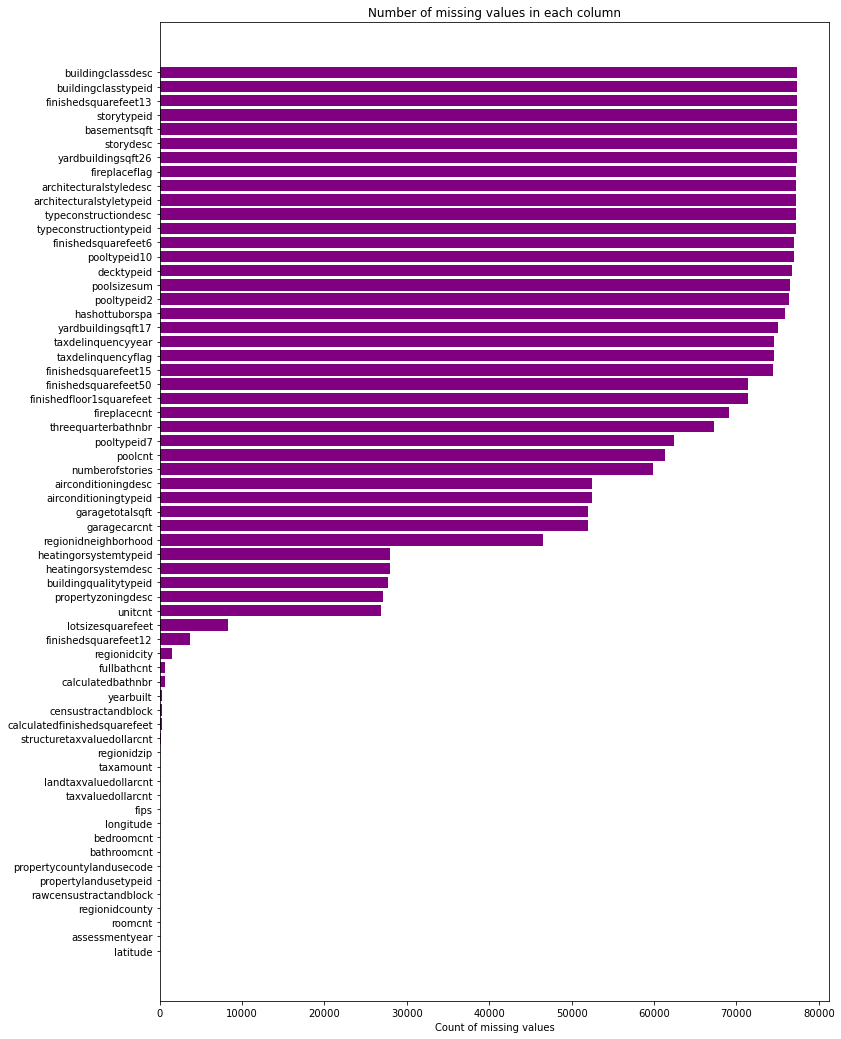

In [4]:
prepare.visualize_nulls(df)

> **How we dealt with Nulls:**<br>
    > - Dropped columns missing >= 50% of values <br>
    > - Nulls in Heatingsystem were filled with None (since properties are in SoCal)
    > - Nulls in lotsizesquarefeet were filled with median  value
    > - Buildingtypequalityid nulls were filled with mode (6.0)
    

***C) Explore Outliers***

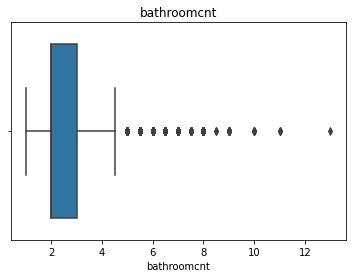

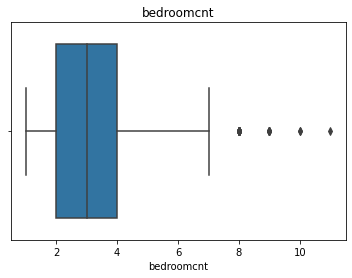

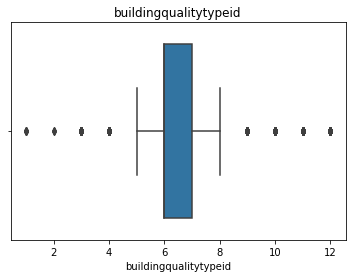

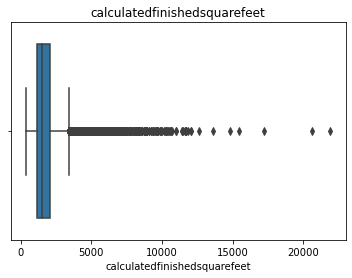

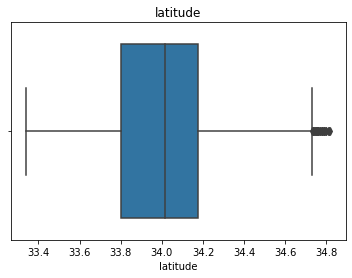

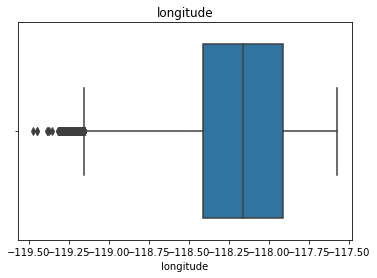

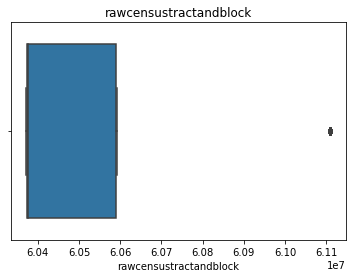

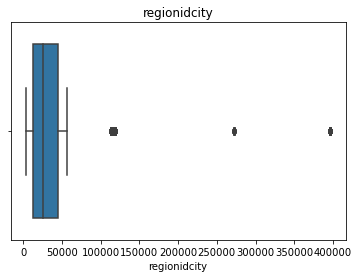

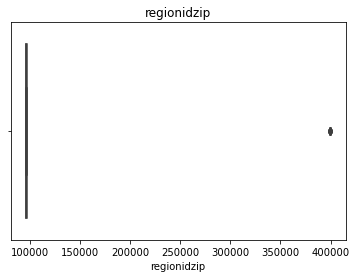

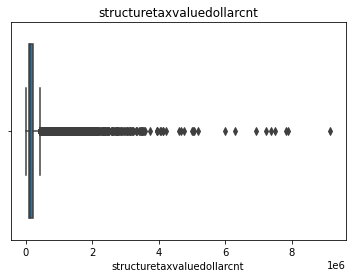

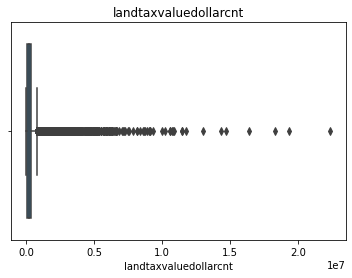

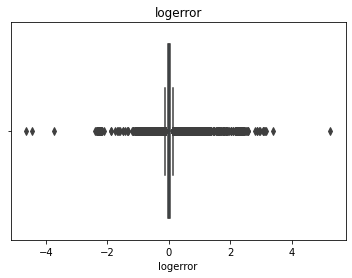

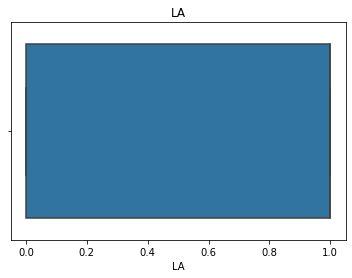

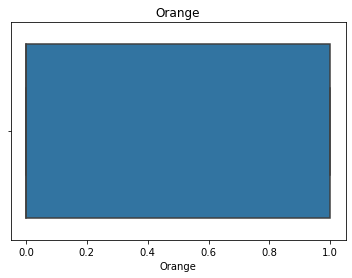

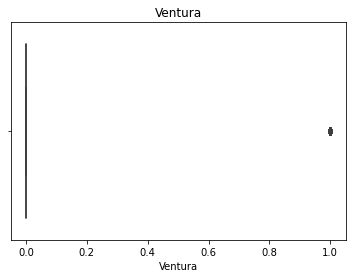

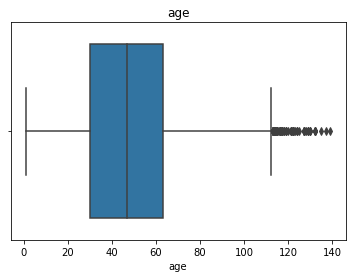

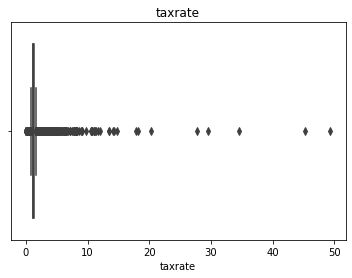

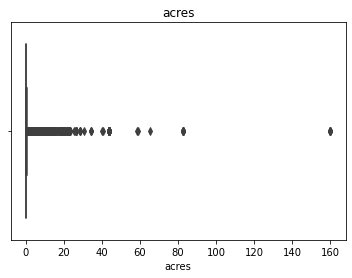

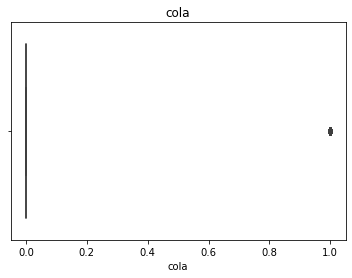

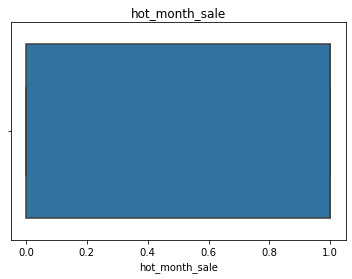

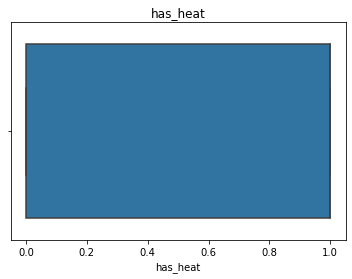

In [5]:
#Visualize Outlier Distribution
prepare.visualize_outliers(df)

In [6]:
#Retrieve report on outliers and the upper and lower bounds based off IQR with a multiplier of 3
prepare.outlier_report(df)

The lower and upper bound of the range for 'bathroomcnt' respectively is: -1.0 and 6.0
The lower and upper bound of the range for 'bedroomcnt' respectively is: -4.0 and 10.0
The lower and upper bound of the range for 'calculatedfinishedsquarefeet' respectively is: -1498.0 and 4718.0
The lower and upper bound of the range for 'acres' respectively is: -0.189 and 0.573
The lower and upper bound of the range for 'rawcensustractandblock' respectively is: 59720887.482 and 61242751.693
The lower and upper bound of the range for 'age' respectively is: -69.0 and 162.0
The lower and upper bound of the range for 'structuretaxvaluedollarcnt' respectively is: -310183.5 and 607458.75
The lower and upper bound of the range for 'taxrate' respectively is: 0.638 and 1.86
The lower and upper bound of the range for 'landtaxvaluedollarcnt' respectively is: -773788.0 and 1224750.5
The lower and upper bound of the range for 'logerror' respectively is: -0.21 and 0.224


> **How we dealt with Outliers**<br>
> - Taxrate<sup>*</sup>: Dropped observations where Tax Rates > 5%
> - Acres<sup>*</sup>: Dropped observations where acres > 12 
> - Squarefeet: Dropped observations where squarefeet > 10,000<br>
>
> -------- <br>
> <sup>*</sup>These are engineered features for this analysis

***D) Clean and Prepare Data***

In [7]:
df = prepare.wrangle_zillow_2nd()
df.head(1)

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,logerror,LA,Orange,Ventura,age,taxrate,acres,cola,hot_month_sale,has_heat
parcelid,,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3.0,8.0,2107.0,6037.0,34.222559,-118.617387,6.037113e+07,12447.0,96339.0,249655.0,374484.0,-0.007357,1,0,0,45.0,1.227188,0.210239,1,1,1


In [8]:
#Columns and dtypes that are used in the analysis that follows
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["feature", "data_type"]
dtype_df

,feature,data_type
0,bathroomcnt,float64
1,bedroomcnt,float64
2,buildingqualitytypeid,float64
3,calculatedfinishedsquarefeet,float64
4,fips,float64
5,latitude,float64
6,longitude,float64
7,rawcensustractandblock,float64
8,regionidcity,float64
9,regionidzip,float64


# Data Exploration

> **Our approach:**
    > - Split the data to explore on the training data set
    > - Run univariate, bivariate, and  multivariate visulaizations for how features interact with each other and the target, logerror
    > - Run statistical tests to help answer questions that arose from exploration
    > - Use clustering to further determine features driving logerror and engineer new features as discovered

### Exploration Prep

In [9]:
#Split the data for exploration
partitions = explore.split(df, target_var='logerror')
train = partitions[0]

In [10]:
#Separate logerror into quantiles for a categorical target
train['logerror_class'] = pd.qcut(train.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])

In [11]:
#Breakdown the features by categories for Univariate and Bivariate Functions from Explore Module
categorical_target = 'logerror_class'
continuous_target = 'logerror'
binary_vars = ['hot_month_sale', 'has_heat','cola', 'LA', 'Orange', 'Ventura']
quant_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

### Univariate Exploration

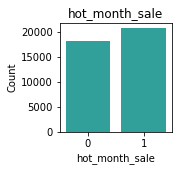

   hot_month_sale  Count  Percent
1               1  20698    53.33
0               0  18112    46.67
_________________________________________________________________


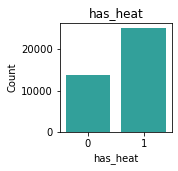

   has_heat  Count  Percent
1         1  25040    64.52
0         0  13770    35.48
_________________________________________________________________


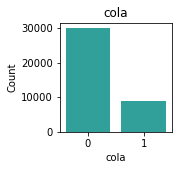

   cola  Count  Percent
0     0  29897    77.03
1     1   8913    22.97
_________________________________________________________________


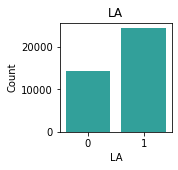

   LA  Count  Percent
1   1  24463    63.03
0   0  14347    36.97
_________________________________________________________________


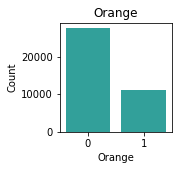

   Orange  Count  Percent
0       0  27639    71.22
1       1  11171    28.78
_________________________________________________________________


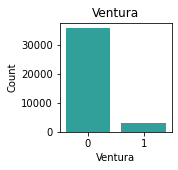

   Ventura  Count  Percent
0        0  35634    91.82
1        1   3176     8.18
_________________________________________________________________


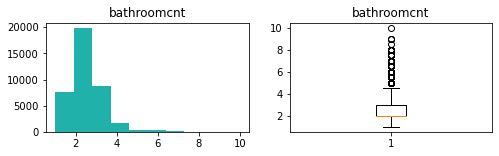

count    38810.000000
mean         2.263025
std          0.933245
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: bathroomcnt, dtype: float64


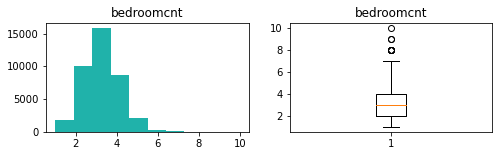

count    38810.000000
mean         3.017083
std          0.996214
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: bedroomcnt, dtype: float64


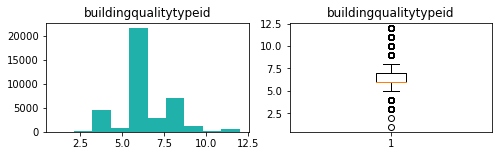

count    38810.000000
mean         6.346071
std          1.363177
min          1.000000
25%          6.000000
50%          6.000000
75%          7.000000
max         12.000000
Name: buildingqualitytypeid, dtype: float64


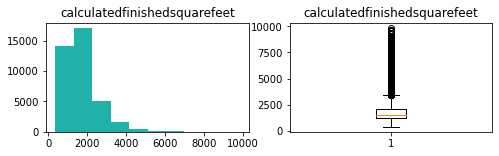

count    38810.000000
mean      1745.602216
std        899.357428
min        360.000000
25%       1166.000000
50%       1511.000000
75%       2054.000000
max       9848.000000
Name: calculatedfinishedsquarefeet, dtype: float64


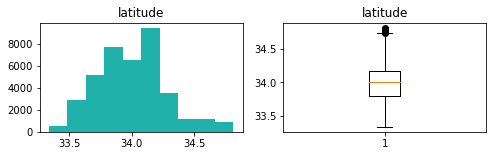

count    38810.000000
mean        34.001031
std          0.268590
min         33.339600
25%         33.801083
50%         34.011400
75%         34.173795
max         34.810638
Name: latitude, dtype: float64


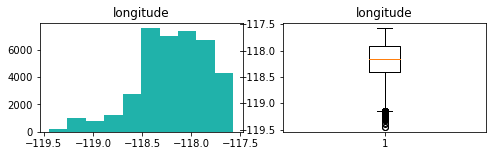

count    38810.000000
mean      -118.192249
std          0.361049
min       -119.448392
25%       -118.408000
50%       -118.161000
75%       -117.913344
max       -117.572338
Name: longitude, dtype: float64


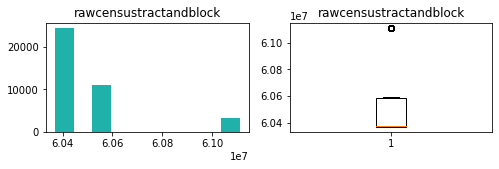

count    3.881000e+04
mean     6.049683e+07
std      2.067733e+05
min      6.037101e+07
25%      6.037312e+07
50%      6.037621e+07
75%      6.059052e+07
max      6.111009e+07
Name: rawcensustractandblock, dtype: float64


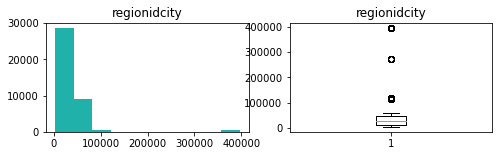

count     38810.000000
mean      33481.498531
std       46735.950323
min        3491.000000
25%       12447.000000
50%       25218.000000
75%       45457.000000
max      396556.000000
Name: regionidcity, dtype: float64


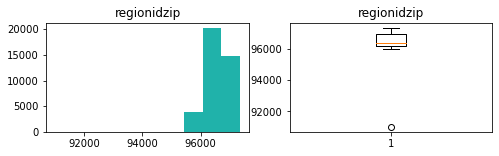

count    38810.000000
mean     96561.873564
std        415.978674
min      91010.000000
25%      96208.000000
50%      96412.000000
75%      96990.000000
max      97344.000000
Name: regionidzip, dtype: float64


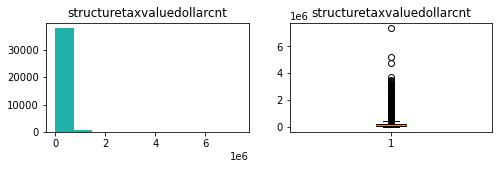

count    3.881000e+04
mean     1.845313e+05
std      2.042976e+05
min      1.810000e+02
25%      8.278000e+04
50%      1.337730e+05
75%      2.140215e+05
max      7.370009e+06
Name: structuretaxvaluedollarcnt, dtype: float64


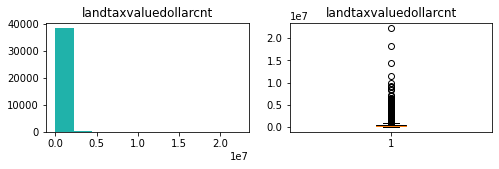

count    3.881000e+04
mean     2.985501e+05
std      4.405111e+05
min      1.393000e+03
25%      8.335950e+04
50%      2.055455e+05
75%      3.678238e+05
max      2.233550e+07
Name: landtaxvaluedollarcnt, dtype: float64


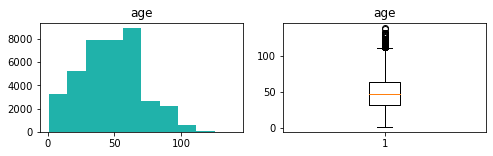

count    38810.000000
mean        47.990415
std         23.015445
min          1.000000
25%         31.000000
50%         47.000000
75%         63.000000
max        139.000000
Name: age, dtype: float64


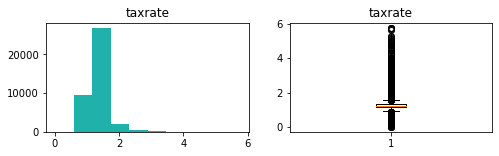

count    38810.000000
mean         1.299984
std          0.296011
min          0.009372
25%          1.162145
50%          1.225265
75%          1.335869
max          5.757539
Name: taxrate, dtype: float64


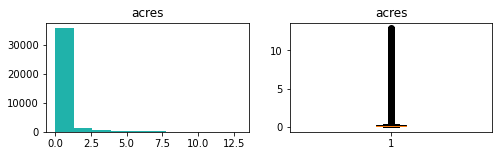

count    38810.000000
mean         0.506413
std          1.291784
min          0.005418
25%          0.137741
50%          0.167883
75%          0.242809
max         12.931451
Name: acres, dtype: float64


In [12]:
explore.explore_univariate(train, binary_vars, quant_vars)

**Takeaways from Univariate Exploration:**

- May - August aren't referred to as hot real estate months for nothing! 53% of all properties sold during that quarter

### Bivariate Exploration

hot_month_sale 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=187796299.0, pvalue=0.7470053713637617)
        chi2   p-value  degrees of freedom
0  21.274907  0.000092                   3

expected:
              0            1            2            3
0  4528.233342  4527.766658  4527.766658  4528.233342
1  5174.766658  5174.233342  5174.233342  5174.766658


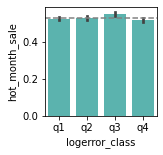


_____________________

has_heat 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=178033627.5, pvalue=9.585614375526934e-08)
         chi2       p-value  degrees of freedom
0  245.718004  5.519869e-53                   3

expected:
              0            1            2            3
0  3442.677403  3442.322597  3442.322597  3442.677403
1  6260.322597  6259.677403  6259.677403  6260.322597


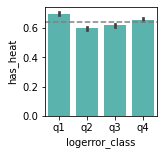


_____________________

cola 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=136249088.0, pvalue=0.0011718183730670406)
         chi2       p-value  degrees of freedom
0  279.031656  3.430525e-60                   3

expected:
              0            1            2            3
0  7474.635171  7473.864829  7473.864829  7474.635171
1  2228.364829  2228.135171  2228.135171  2228.364829


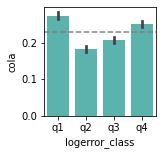


_____________________

LA 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=180281936.0, pvalue=6.729640971002512e-06)
         chi2       p-value  degrees of freedom
0  277.428384  7.625431e-60                   3

expected:
              0            1            2            3
0  3586.934836  3586.565164  3586.565164  3586.934836
1  6116.065164  6115.434836  6115.434836  6116.065164


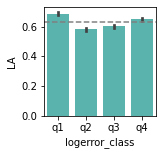


_____________________

Orange 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=151392152.0, pvalue=0.0028118979595027804)
         chi2       p-value  degrees of freedom
0  206.373753  1.769561e-44                   3

expected:
              0            1            2            3
0  6910.106081  6909.393919  6909.393919  6910.106081
1  2792.893919  2792.606081  2792.606081  2792.893919


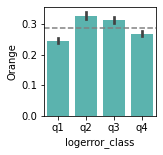


_____________________

Ventura 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=54775669.0, pvalue=0.0027573997976943682)
        chi2       p-value  degrees of freedom
0  35.080387  1.171527e-07                   3

expected:
              0            1            2            3
0  8908.959083  8908.040917  8908.040917  8908.959083
1   794.040917   793.959083   793.959083   794.040917


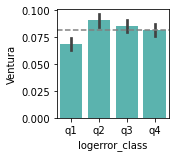


_____________________

bathroomcnt 
____________________



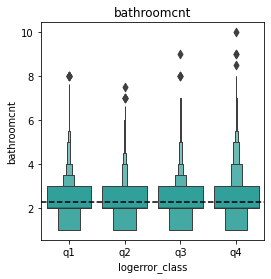

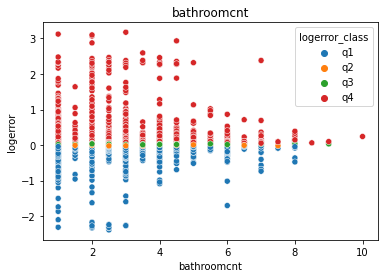

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean               2.169638     2.234333     2.285096     2.363032
std                0.921092     0.825203     0.863324     1.090545
min                1.000000     1.000000     1.000000     1.000000
25%                2.000000     2.000000     2.000000     2.000000
50%                2.000000     2.000000     2.000000     2.000000
75%                3.000000     3.000000     3.000000     3.000000
max                8.000000     7.500000     9.000000    10.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.06214756575452329, pvalue=1.5857384743623378e-34)

____________________

bedroomcnt 
____________________



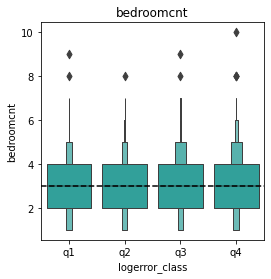

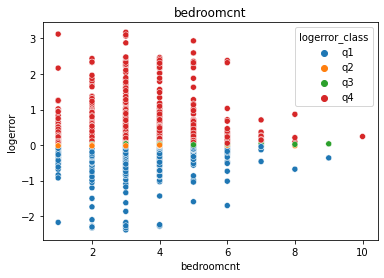

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean               2.931464     3.007937     3.034529     3.094404
std                0.966210     0.956555     0.981082     1.070178
min                1.000000     1.000000     1.000000     1.000000
25%                2.000000     2.000000     2.000000     2.000000
50%                3.000000     3.000000     3.000000     3.000000
75%                4.000000     4.000000     4.000000     4.000000
max                9.000000     8.000000     9.000000    10.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.05580439134202919, pvalue=3.7447230770590724e-28)

____________________

buildingqualitytypeid 
____________________



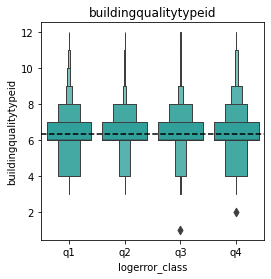

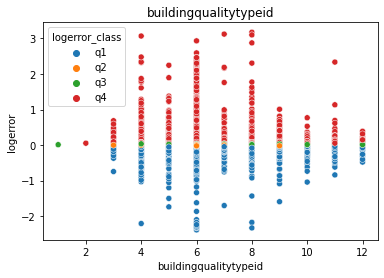

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean               6.315779     6.332818     6.385900     6.349789
std                1.420992     1.266976     1.303188     1.451931
min                3.000000     3.000000     1.000000     2.000000
25%                6.000000     6.000000     6.000000     6.000000
50%                6.000000     6.000000     6.000000     6.000000
75%                7.000000     7.000000     7.000000     7.000000
max               12.000000    12.000000    12.000000    12.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.0035052506159225145, pvalue=0.48986525848709395)

____________________

calculatedfinishedsquarefeet 
____________________



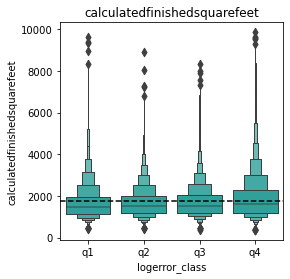

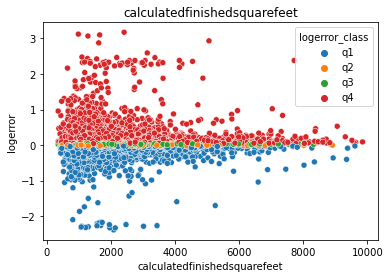

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean            1675.311141  1675.314471  1731.954649  1899.819953
std              866.120802   763.440881   813.169319  1098.854694
min              419.000000   418.000000   360.000000   360.000000
25%             1129.500000  1162.000000  1190.250000  1197.000000
50%             1447.000000  1488.500000  1534.000000  1586.000000
75%             1947.000000  1986.000000  2056.000000  2275.500000
max             9611.000000  8909.000000  8322.000000  9848.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.07571124779012368, pvalue=1.9139863599396248e-50)

____________________

latitude 
____________________



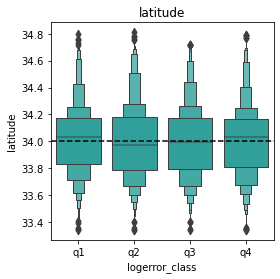

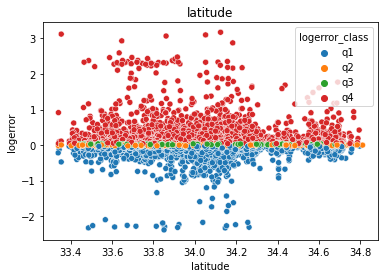

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean              34.014013    33.995763    33.993230    34.001117
std                0.257285     0.283530     0.271676     0.260644
min               33.339600    33.341282    33.340658    33.340851
25%               33.830175    33.783921    33.791075    33.811966
50%               34.032307    33.974041    33.992128    34.030477
75%               34.171084    34.183207    34.176293    34.167430
max               34.796863    34.810638    34.718286    34.794327 


Spearman's Correlation Test:
 SpearmanrResult(correlation=-0.013660747528455279, pvalue=0.0071186787815554035)

____________________

longitude 
____________________



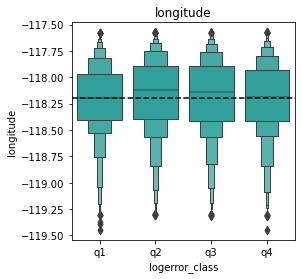

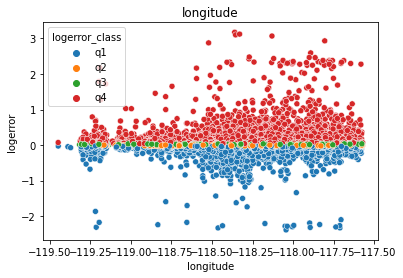

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean            -118.211896  -118.170371  -118.178275  -118.208450
std                0.337744     0.373297     0.370002     0.360310
min             -119.447944  -119.304940  -119.316449  -119.448392
25%             -118.406605  -118.394600  -118.409163  -118.418276
50%             -118.197049  -118.120807  -118.138387  -118.185363
75%             -117.965698  -117.888605  -117.887105  -117.926650
max             -117.576185  -117.572421  -117.573418  -117.572338 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.00908397431546221, pvalue=0.07352704286279804)

____________________

rawcensustractandblock 
____________________



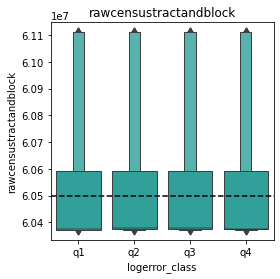

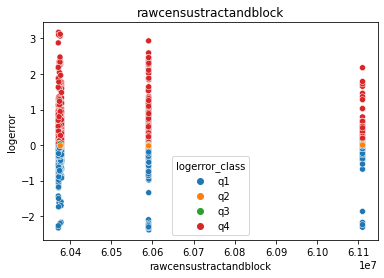

logerror_class            q1            q2            q3            q4
count           9.703000e+03  9.702000e+03  9.702000e+03  9.703000e+03
mean            6.047772e+07  6.051198e+07  6.050515e+07  6.049248e+07
std             1.947348e+05  2.132878e+05  2.098026e+05  2.071732e+05
min             6.037101e+07  6.037101e+07  6.037101e+07  6.037101e+07
25%             6.037272e+07  6.037405e+07  6.037402e+07  6.037297e+07
50%             6.037571e+07  6.037901e+07  6.037670e+07  6.037578e+07
75%             6.059042e+07  6.059053e+07  6.059052e+07  6.059042e+07
max             6.111009e+07  6.111009e+07  6.111009e+07  6.111009e+07 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.018188168669041417, pvalue=0.0003392852927900933)

____________________

regionidcity 
____________________



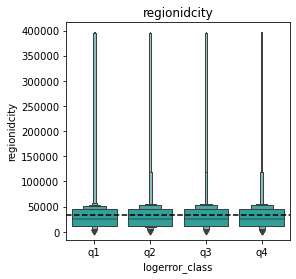

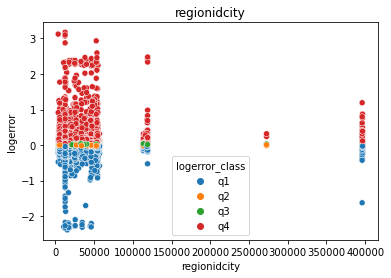

logerror_class             q1             q2             q3             q4
count             9703.000000    9702.000000    9702.000000    9703.000000
mean             34019.375245   33459.553906   33285.348897   33161.693600
std              51206.669600   45790.830289   44407.898067   45235.225036
min               3491.000000    3491.000000    3491.000000    3491.000000
25%              12447.000000   12447.000000   12447.000000   12447.000000
50%              24812.000000   25218.000000   25218.000000   24832.000000
75%              45457.000000   44833.000000   45398.000000   45457.000000
max             396556.000000  396556.000000  396556.000000  396556.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.015703274968725926, pvalue=0.001976931761793668)

____________________

regionidzip 
____________________



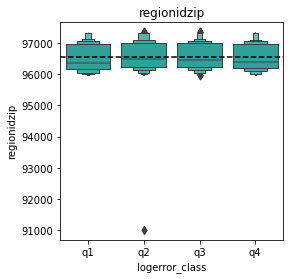

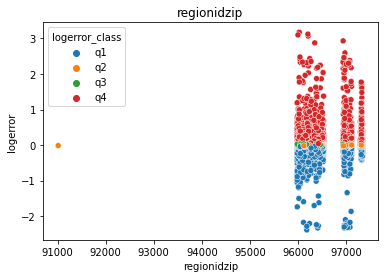

logerror_class            q1            q2            q3            q4
count            9703.000000   9702.000000   9702.000000   9703.000000
mean            96511.348449  96615.624923  96585.147186  96535.381635
std               416.648144    418.628384    408.013701    412.552653
min             95982.000000  91010.000000  95982.000000  95982.000000
25%             96163.000000  96237.000000  96225.000000  96186.000000
50%             96371.000000  96475.000000  96449.000000  96387.000000
75%             96978.000000  97002.500000  96993.000000  96983.000000
max             97344.000000  97344.000000  97344.000000  97344.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.017948269701506637, pvalue=0.000406195327152505)

____________________

structuretaxvaluedollarcnt 
____________________



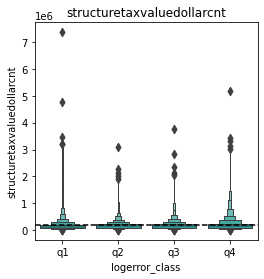

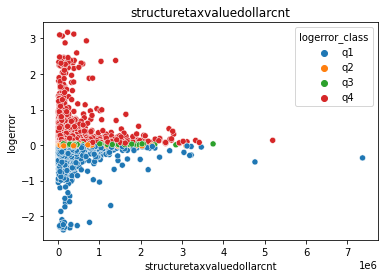

logerror_class            q1            q2            q3            q4
count           9.703000e+03  9.702000e+03  9.702000e+03  9.703000e+03
mean            1.774456e+05  1.726191e+05  1.816767e+05  2.063821e+05
std             2.138364e+05  1.494687e+05  1.734626e+05  2.610091e+05
min             3.282000e+03  1.810000e+02  1.015000e+03  7.840000e+02
25%             7.794200e+04  8.700000e+04  8.894425e+04  7.840200e+04
50%             1.278520e+05  1.357585e+05  1.393835e+05  1.324260e+05
75%             2.023005e+05  2.091672e+05  2.172170e+05  2.331115e+05
max             7.370009e+06  3.097672e+06  3.751075e+06  5.194843e+06 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.025775560100944193, pvalue=3.803645917633288e-07)

____________________

landtaxvaluedollarcnt 
____________________



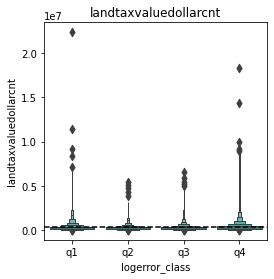

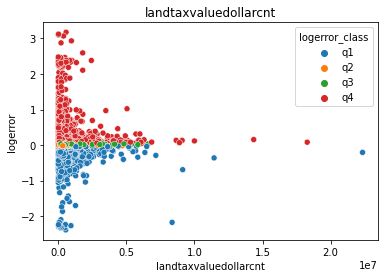

logerror_class            q1            q2            q3            q4
count           9.703000e+03  9.702000e+03  9.702000e+03  9.703000e+03
mean            3.072764e+05  2.616646e+05  2.825550e+05  3.426989e+05
std             5.050437e+05  2.703803e+05  3.371358e+05  5.751193e+05
min             1.393000e+03  4.747000e+03  5.230000e+03  2.211000e+03
25%             7.772250e+04  9.185725e+04  9.214825e+04  7.163800e+04
50%             2.025500e+05  2.066220e+05  2.133520e+05  1.994740e+05
75%             3.670685e+05  3.479900e+05  3.633500e+05  4.030750e+05
max             2.233550e+07  5.384780e+06  6.598604e+06  1.827450e+07 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.006170459033126605, pvalue=0.22414933654026456)

____________________

age 
____________________



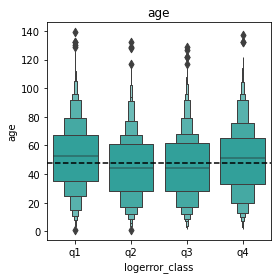

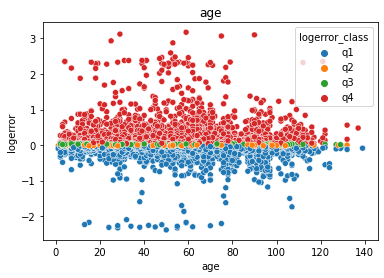

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean              52.183964    44.622346    45.061224    50.093476
std               23.503730    21.726458    22.177707    23.680090
min                1.000000     1.000000     2.000000     2.000000
25%               35.000000    28.000000    28.000000    33.000000
50%               53.000000    44.000000    44.000000    51.000000
75%               67.000000    61.000000    62.000000    65.000000
max              139.000000   132.000000   129.000000   137.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=-0.031172577081100397, pvalue=8.129838255452216e-10)

____________________

taxrate 
____________________



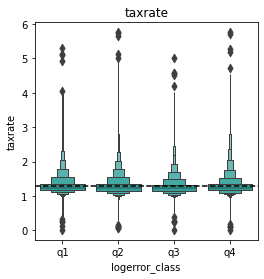

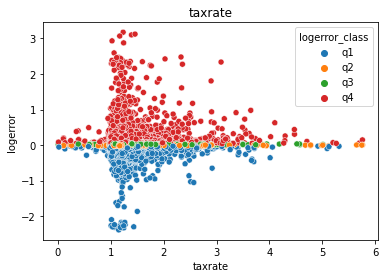

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean               1.308791     1.299721     1.287573     1.303850
std                0.295718     0.303381     0.266993     0.315428
min                0.022955     0.078687     0.009372     0.015673
25%                1.173528     1.156098     1.156570     1.161459
50%                1.227718     1.223761     1.223420     1.226209
75%                1.339351     1.338766     1.330803     1.333111
max                5.313725     5.757539     5.010001     5.755507 


Spearman's Correlation Test:
 SpearmanrResult(correlation=-0.01182707046462336, pvalue=0.019807771829809754)

____________________

acres 
____________________



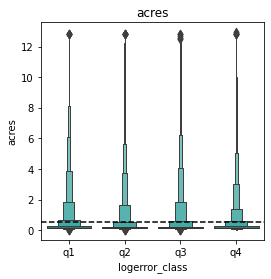

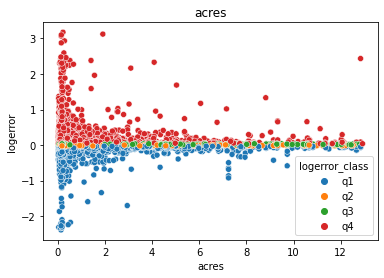

logerror_class           q1           q2           q3           q4
count           9703.000000  9702.000000  9702.000000  9703.000000
mean               0.526103     0.497170     0.530012     0.472370
std                1.309159     1.318244     1.362115     1.168827
min                0.005418     0.009986     0.014692     0.009986
25%                0.138154     0.137741     0.137741     0.137741
50%                0.167883     0.167883     0.167883     0.167883
75%                0.252491     0.218876     0.234160     0.275482
max               12.848600    12.848600    12.848600    12.931451 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.00766696421552801, pvalue=0.13094522464345973)

____________________



In [13]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

**Takeaways from Bivariate Exploration:**
- Logerror centers closer to zero as property age > 85
- Logerror is more accurate for properties with more acres
- Logerror by county
    - for properties in LA County logerror tend more towards q1 and q4
    - for properties in Orange County, logerror favors the middle two quartiles
    - for Ventura county properties, logerror is more in the upper 75%

### Multivariate Exploration

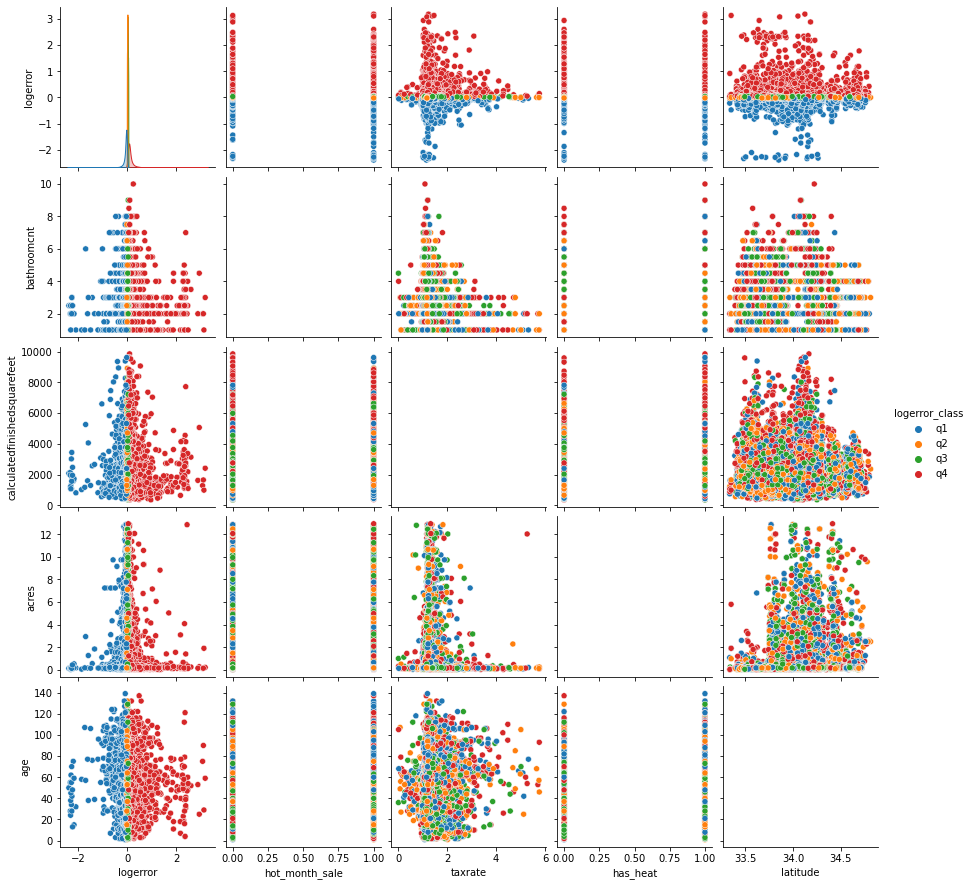

In [14]:
sns.pairplot(data = train, hue = 'logerror_class', 
             x_vars = ['logerror','hot_month_sale','taxrate', 'has_heat', 'latitude'
                       ],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

**Takeaways from Multivariate Exploration:**
- As acres increase, logerror appears to tighten around 0
- Let's take a look at this further!

Text(0.5, 1.0, 'Is logerror affected by the number of acres a property has?')

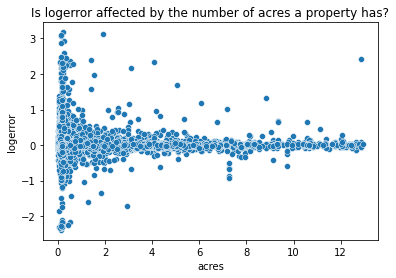

In [15]:
#Visualize how logerror and acres interact
sns.scatterplot(x='acres', y='logerror', data=train)
plt.title('Is logerror affected by the number of acres a property has?')

### QUESTIONS FROM VISUAL EXPLORATION
#### **1. Do properties with more acres have different logerrors than properties with less acres?**
#### **2. Does Logerror correlate with whether or not a property was sold duing a 'hot month' of real estate (May - Aug)?**
#### **3. Does logerror significantly vary by county?**

---

## Exploration with Statistical Testing

**Do properties with more acres have different logerrors than properties with less acres?**

We ran a mann-whitney u test to analyze this due to the fact that logerror is not normally distirbuted<br>
**H<sub>o</sub>: Properties with more than 5 acres do not have a different logerror mean than properties with less acres.<br>
H<sub>a</sub>: Properties with more than 5 acres have a different logerror mean than properties with less acres**

In [16]:
#Set confidence interval and alpha for Mann-Whitney U Test due to the fact that logerror is not normally dist
confidence_interval = 0.95
a = 1 - confidence_interval 

#Define the two samples where x1 is properties with 5 or more acres and x2 is properties with less than 5 acres
x1 = train[train.acres >= 5].logerror
x2 = train[train.acres < 5].logerror

#Run the test
t, p = stats.mannwhitneyu(x1, x2)

#print results
print(f'The mannwhitneyu statistic is:{t} and the p-value is {p}')

if p < a:
    print('We reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis')

The mannwhitneyu statistic is:14582957.5 and the p-value is 0.04029329779815308
We reject the null hypothesis.


---

**Does Logerror correlate with whether or not a property was sold duing a 'hot month' of real estate (May - Aug)?<br>**

We ran a pearson's correlation coefficient test to answer this.<br>
**H<sub>o</sub>: There is no correlation between logerror and hot month sale for a property.<br>
H<sub>a</sub>: There is a correlation between logerror and hot month sale for a property.**

In [17]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_interval = 0.95
a = 1 - confidence_interval 

#Use personr function
corr, p = stats.pearsonr(train.hot_month_sale, train.logerror)

print(f"Pearson's correlation coefficient: {corr} and p-value is: {p}")
if p < a:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Pearson's correlation coefficient: -0.011103623413005956 and p-value is: 0.028710494324764028
We reject the null hypothesis.


---

**Does logerror significantly vary by county?**

We ran a mann-whitney u test to analyze this due to the fact that logerror is not normally distirbuted<br>
**H<sub>o</sub>: Mean Logerror score is not significantly greater for LA County than for Orange/Venura County<br>
H<sub>a</sub>: Mean Logerror score is significantly greater for LA county than for Orange/Ventura County**

In [18]:
#Set confidence interval and alpha for Mann-Whitney U Test due to the fact that logerror is not normally dist
confidence_interval = 0.95
a = 1 - confidence_interval 

#Define the two samples where x1 is properties with 5 or more acres and x2 is properties with less than 5 acres
x1 = train[train.LA == 1].logerror
x2 = train[train.LA != 1].logerror

#Run the test
u, p = stats.mannwhitneyu(x2, x1, alternative='greater') 

#print results
print(f'The mannwhitneyu statistic is: {u} and the p-value is {p}')

if p < a:
    print('We reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis')

The mannwhitneyu statistic is: 180281936.0 and the p-value is 3.364820485501256e-06
We reject the null hypothesis.


---

## Exploration Using Clustering

**Our Approach**
> - Analysis from linear regression project highlighted different variances by county in the residuals for predicting taxvaluedollarcnt.
> - We will approacg predicting logerror by controlling for county in our models.
> - The goal is to deliver three models (one for each county) that are designed specifically for those counties, where we can modify the parameters and features the county models are trained on.
> - For clustering then, we will explore on segmented dataframes by county.

### Clustering Set-Up For Clustering Without Controlling for County

In [19]:
# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres', 'fips']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]

scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [20]:
#Set X_train to X[0] (Partitions[1] = X_train = X[0])
X_train = X[0]

### Cluster 1: Latitude and Longitude

In [21]:
# define independent variables for k-means
X = X_train[['scaled_latitude', 'scaled_longitude']]

**Confirm k is set to the best value for number of clusters**

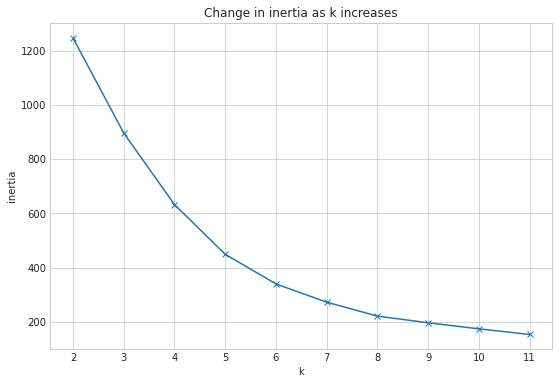

In [22]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [23]:
#define the thing
kmeans = KMeans(n_clusters=4)
cluster_vars = ['scaled_latitude', 'scaled_longitude']
k_range = range(2,12)
explore.find_k(X_train, cluster_vars, k_range)

,k,sse,delta,pct_delta
0,2,1248.846984,352.0,28.2
1,3,897.186140,264.0,29.5
2,4,632.907124,184.0,29.1
3,5,449.046966,109.0,24.4
4,6,339.588881,68.0,19.9
5,7,272.055688,51.0,18.9
6,8,220.626181,25.0,11.2
7,9,195.895556,22.0,11.4
8,10,173.470062,21.0,12.0


**Fit and Train the Kmeans Cluster Object with k = 4**

Text(0.5, 1.0, 'Clusters of Properties by Latitude & Longitude (scaled)')

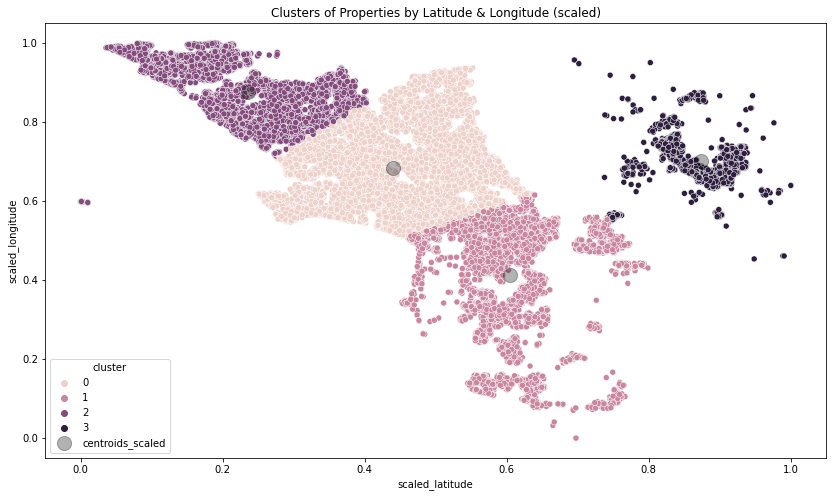

In [24]:
#define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

# make a new column names cluster in X_train and X[0] dataframe
X_train['cluster'] = kmeans.predict(X)

# Cluster Centers aka centroids - THE OUTPUT IS SCALED 
kmeans.cluster_centers_

# Make a dataframe of the Centroids for visualization
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

#Plot the clusters and centroids
plt.figure(figsize=(14,8))

sns.scatterplot(x='scaled_latitude', y='scaled_longitude', data=X_train, hue='cluster')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x='scaled_latitude', y='scaled_longitude', ax=plt.gca(), color='k', alpha = 0.3, s = 200, marker = 'o', label = 'centroids_scaled')

plt.title('Clusters of Properties by Latitude & Longitude (scaled)')

In [25]:
#Drop cluster column so we can create more clusters
X_train.drop(columns={'cluster'}, inplace=True)

---

### Clustering Setup For Properties only Located in Los Angeles County

**Filtered for LA County Properties only**

In [26]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 

#Preview the shape of the acquired dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df_la.shape[0], df_la.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       43768 │          19 │
╘══════════════════╧═════════════╧═════════════╛


**Split LA County Data Frame into train, validate, test and scale necessary values**

In [27]:
#Split LA County Data Frame into train, validate, test, etc...
partitions = explore.split(df_la, target_var='logerror')
train = partitions[0]
partitions[0] = train

# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]

scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [28]:
#Set X_train to X[0] (Partitions[1] = X_train = X[0])
X_train = X[0]

#Confirm Scaled Columns are in X_train
X_train.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'age', 'taxrate',
       'acres', 'cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres'],
      dtype='object')

---

### Cluster 2 : Cluster properties using scaled_buildingqualitytypeid and scaled_age

In [29]:
# define independent variables for k-means
X = X_train[['scaled_buildingqualitytypeid', 'scaled_age']]

**Confirm the correct/best value for k number of clusters**

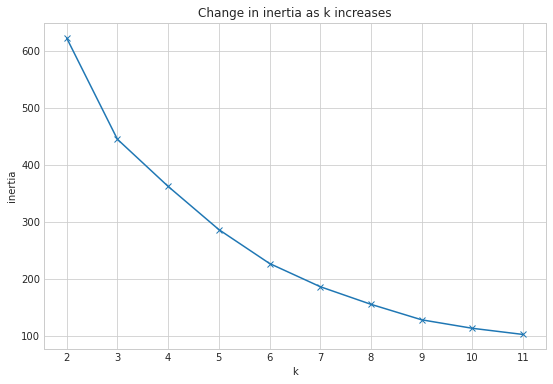

In [30]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [31]:
#define the thing
kmeans = KMeans(n_clusters=4)
cluster_vars = ['scaled_buildingqualitytypeid', 'scaled_age']
k_range = range(2,12)
explore.find_k(X_train, cluster_vars, k_range)

,k,sse,delta,pct_delta
0,2,622.647328,178.0,28.6
1,3,444.870019,83.0,18.6
2,4,362.061815,76.0,20.9
3,5,286.275837,60.0,20.8
4,6,226.700487,41.0,18.0
5,7,185.936518,31.0,16.6
6,8,155.023004,27.0,17.6
7,9,127.778032,15.0,11.6
8,10,112.961633,11.0,9.6


**Fit and Train the Kmeans Cluster Object with k = 4**

Text(0.5, 1.0, 'Clusters of Properties by Building Quality and Age (scaled)')

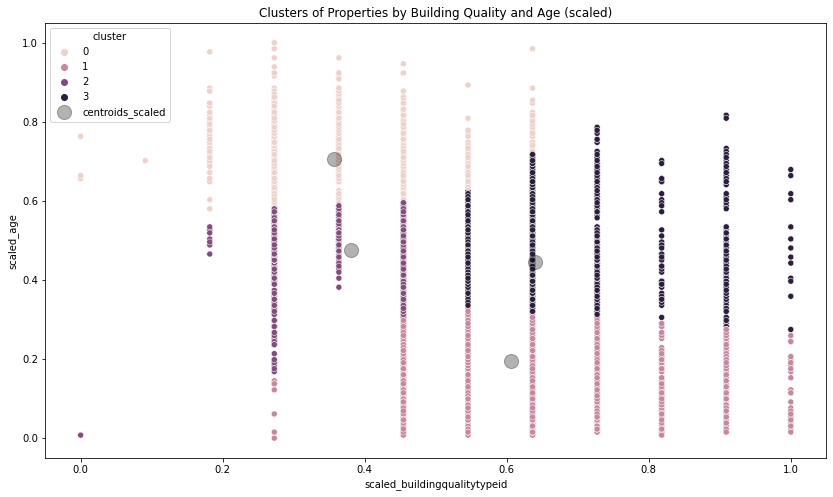

In [32]:
#define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

# make a new column names cluster in X_train and X[0] dataframe
X_train['cluster'] = kmeans.predict(X)

# Cluster Centers aka centroids - THE OUTPUT IS SCALED 
kmeans.cluster_centers_

# Make a dataframe of the Centroids for visualization
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

#Plot the clusters and centroids
plt.figure(figsize=(14,8))

sns.scatterplot(x='scaled_buildingqualitytypeid', y='scaled_age', data=X_train, hue='cluster')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x='scaled_buildingqualitytypeid', y='scaled_age', ax=plt.gca(), color='k', alpha = 0.3, s = 200, marker = 'o', label = 'centroids_scaled')

plt.title('Clusters of Properties by Building Quality and Age (scaled)')

In [33]:
#Drop cluster column so we can create more clusters
X_train.drop(columns={'cluster'}, inplace=True)

---

### Cluster 3: Create Clusters on Size using square feet and acres

In [34]:
# define independent variables for k-means
X = X_train[['scaled_calculatedfinishedsquarefeet', 'scaled_acres']]

**Confirm the correct/best value for k number of clusters**

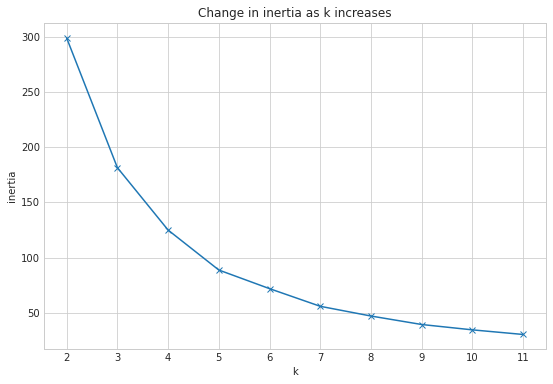

In [35]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [36]:
#define the thing
kmeans = KMeans(n_clusters=4)
cluster_vars = ['scaled_calculatedfinishedsquarefeet', 'scaled_acres']
k_range = range(2,12)
explore.find_k(X_train, cluster_vars, k_range)

,k,sse,delta,pct_delta
0,2,298.955532,117.0,39.3
1,3,181.509599,57.0,31.1
2,4,124.974833,36.0,29.0
3,5,88.772642,17.0,19.0
4,6,71.899360,16.0,22.3
5,7,55.891590,9.0,15.7
6,8,47.110931,8.0,16.2
7,9,39.458156,5.0,12.4
8,10,34.583381,4.0,12.1


**Fit and Train the Kmeans Cluster Object with k = 4**

Text(0.5, 1.0, 'Clusters of Properties by Square Feet and Acres (scaled)')

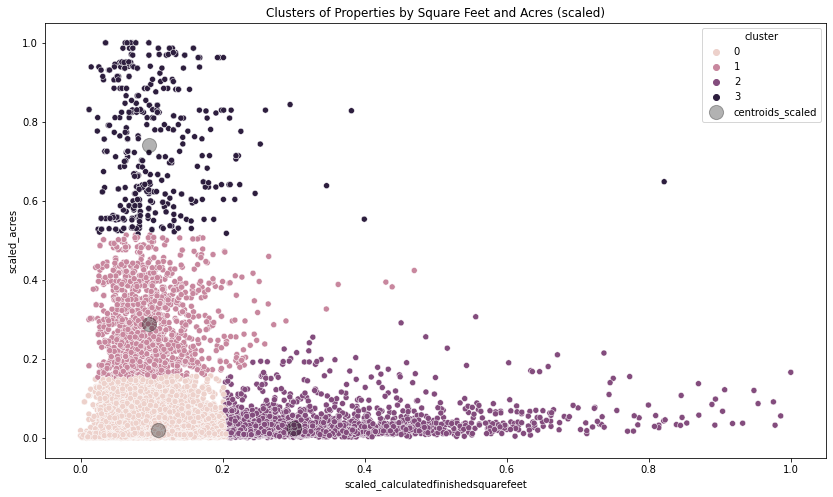

In [37]:
#define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

# make a new column names cluster in X_train and X[0] dataframe
X_train['cluster'] = kmeans.predict(X)

# Cluster Centers aka centroids - THE OUTPUT IS SCALED 
kmeans.cluster_centers_

# Make a dataframe of the Centroids for visualization
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

#Plot the clusters and centroids
plt.figure(figsize=(14,8))

sns.scatterplot(x='scaled_calculatedfinishedsquarefeet', y='scaled_acres', data=X_train, hue='cluster')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x='scaled_calculatedfinishedsquarefeet', y='scaled_acres', ax=plt.gca(), color='k', alpha = 0.3, s = 200, marker = 'o', label = 'centroids_scaled')

plt.title('Clusters of Properties by Square Feet and Acres (scaled)')

In [38]:
#Drop cluster column so we can create more clusters
X_train.drop(columns={'cluster'}, inplace=True)

**Takeaways:**
Clustering by acres and finished squarefeet of the structural unit returns 4 clusters.
Initial assumptions about what the clusters *could* be labelled as with more research:
- Properties with a lot of land, but smaller houses (Rural homes)
- Properties with a moderate amount of land and moderate amount of square footage (suburban homes)
- Properties with very small amount of land and small homes (Avg city dweller / Apt)
- Properties with small amounts of land but the  most squarefootage (Large Condos, Large Homes in Urban Cores)

---

# Modeling and Evaluation

### Modeling Approach

**Target: Logerror**
> **1st: Developed a baseline model and linear regression model without controlling for counties (all three counties included)**
    > - Baseline Model performed best on the mean
    > - Use KBest to select the top 5 features for predicting logerror
    > - Fit training data to a linear regression model
    > - Evaluated against the baseline accuracy model
    > - If LM model imporved baseline, evaluated on validate data set
    
> **2nd: Iterate Process for each of the three counties:**
    > - Baseline Model with mean
    > - Use KBest to select top 5 features
    > - Fit training data to a linear regression model
    > - Evaluated against the baseline accurancy model
    > - If LM model improved baseline, evaluated on validate data set
    
> **3rd: Evaluate if the individualized county models performed better than the all counties model**

## <font color=brown>All Counties Modeling</font>

<font color=brown>***Split and Scale the Dataframe with properties from all three counties included***</grey>

In [39]:
#Split All County Data Frame into train, validate, test, etc...
partitions = explore.split(df, target_var='logerror')
train = partitions[0]
partitions[0] = train

# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]

scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])
    
#Define the other dataframes from partitions
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

In [40]:
#Set X_train_scaled to the dataframe with scaled features
X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

<font color=brown>***Use Select K-Best to Determine the Best Features for Predicting Logerror***</grey>

In [41]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train_scaled, y_train)

#Return top 5 features

f_support = f_selector.get_support()
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
print(f'Select KBest returned the top 5 features for predicting logerror for ALL COUNTIES as: {f_feature}')

Select KBest returned the top 5 features for predicting logerror for ALL COUNTIES as: ['cola', 'scaled_bathroomcnt', 'scaled_bedroomcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_regionidzip']


### <font color=brown>Baseline Model (All Counties)</font>

<font color=brown>***The mean performed better than the median for a basline model***</font>

In [42]:
# 1. Predict logerror_pred_mean
yhat_baseline = y_train['logerror'].mean()
y_train['yhat_baseline'] = yhat_baseline

#Evaluate the baseline model using the mean
all_county_baseline_stats = pd.DataFrame([evaluate.baseline_mean_errors(y_train.logerror)])
all_county_baseline_stats

,sse,mse,rmse
0,1065.209515,0.027447,0.165671


### <font color=brown> Linear Regression Model for All Counties </font>

<font color=brown> ***The Linear Regression Model Performed the best on in-sample data of the models we evaluated***</font>

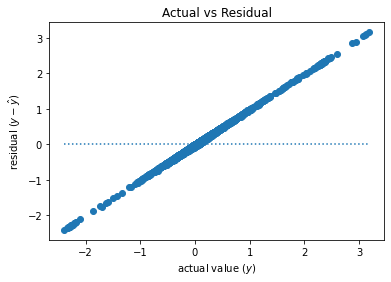

,sse,ess,tss,mse,rmse,r^2
0,1062.311475,2.89804,1065.209515,0.027372,0.165445,0.002721


In [43]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['cola',
 'scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['cola',
 'scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
pd.DataFrame(evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)).T

<div class="alert alert-block alert-info"><b>Takeaway:</b> Though the linear regression model performed the best out of the models attempted, it did not perform significantly better than the baseline model on in-sample data and therefore we will not proceed with this model.</div>

### <font color=brown> Out of Sample Performance for Linear Regression Model (All Counties) </font>

In [44]:
X_validate_scaled = X[1][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

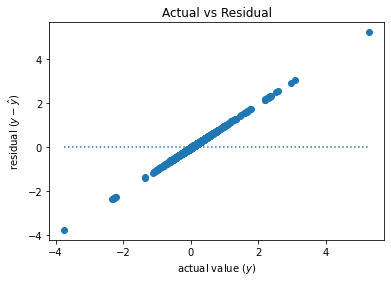

,sse,ess,tss,mse,rmse,r^2
0,457.256636,12.404901,445.4054,0.027489,0.165799,0.027851


In [45]:
# predict validate
y_validate['yhat_lm'] = lm.predict(X_validate_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.logerror, y_validate.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
ac_lm_eval = pd.DataFrame(evaluate.regression_errors(y_validate.logerror, y_validate.yhat_lm)).T
ac_lm_eval

---

## Modeling By Individual Counties

### <font color=purple>  Los Angeles County Propetries</font>

In [46]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 

#Preview the shape of the acquired dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df_la.shape[0], df_la.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       43768 │          19 │
╘══════════════════╧═════════════╧═════════════╛


In [47]:
#Split the Los Angeles County Dataframe into train, validate and test
partitions = explore.split(df_la, target_var='logerror')

#assign train to partitions[0]
train = partitions[0]
partitions[0] = train

In [48]:
# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

#Define scale and concat function to assist with scaling the dataframes
def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

#Scale partitions[1:4]
for i in range(len(X)):
    X[i] = scale_and_concat(X[i])
 

In [49]:
#Reassign partitions to their corresponding dataframes
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

In [50]:
X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

 <font color=purple>***Use Select K-Best to Determine the Best Features for Predicting Logerror***</purple>

In [51]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train_scaled, y_train)

#Return top 5 features
f_support = f_selector.get_support()
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
print(f'Select KBest returned the top 5 features for predicting logerror for LOS ANGELES COUNTY as: {f_feature}')

Select KBest returned the top 5 features for predicting logerror for LOS ANGELES COUNTY as: ['scaled_bathroomcnt', 'scaled_bedroomcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_regionidzip', 'scaled_taxrate']


###  <font color=purple>Baseline Model (LA County) </font>

 <font color=purple>***The mean performed better than the median for a basline model***</font>

In [52]:
# 1. Predict logerror_pred_mean
yhat_baseline = y_train['logerror'].mean()
y_train['yhat_baseline'] = yhat_baseline

#Evaluate the baseline model using the mean
la_baseline_stats = pd.DataFrame([evaluate.baseline_mean_errors(y_train.logerror)])
la_baseline_stats

,sse,mse,rmse
0,607.355178,0.024781,0.15742


###  <font color=purple> Linear Regression Model (LA County) </font>

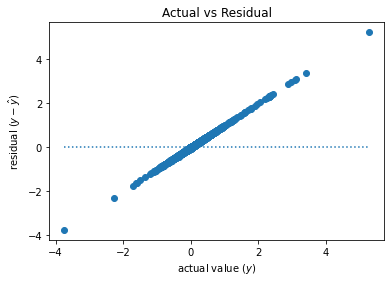

,sse,ess,tss,mse,rmse,r^2
0,605.88955,1.465628,607.355178,0.024721,0.157229,0.002413


In [53]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
pd.DataFrame(evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)).T

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model performs only marginally better than baseline on in-sample data.</div>

###  <font color=purple>Out of Sample Performance for Linear Regression Model (LA County) </font>

In [54]:
X_validate_scaled = X[1][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

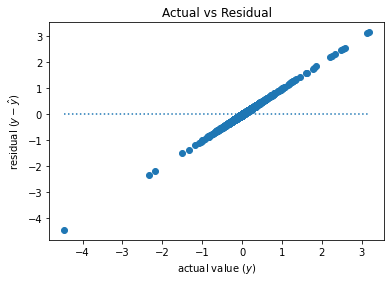

,sse,ess,tss,mse,rmse,r^2
0,272.846257,0.643601,273.290654,0.025973,0.161161,0.002355


In [55]:
# predict validate
y_validate['yhat_lm'] = lm.predict(X_validate_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['logerror']
#y_validate['baseline_residual'] = y_validate['yhat_baseline'] - y_validate['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.logerror, y_validate.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on out-of-sample data
la_lm_eval = pd.DataFrame(evaluate.regression_errors(y_validate.logerror, y_validate.yhat_lm)).T
la_lm_eval

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model does not perform better than the baseline model on out of sample data. It does perform slightly better than the lm model that does not control for county.</div>

---

###  <font color=blue>Ventura County Properties</font>

In [56]:
#Create Ventura County df
df_vent = df[df.Ventura == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 

#Split the Data
partitions = explore.split(df_vent, target_var='logerror')
train = partitions[0]
partitions[0] = train

# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)
for i in range(len(X)):
    X[i] = scale_and_concat(X[i])
    
#Define the other dataframes from partitions
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

In [57]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train_scaled, y_train)

#Return top 5 features

f_support = f_selector.get_support()
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
print(f'Select KBest returned the top 5 features for predicting logerror for VENTURA COUNTY as: {f_feature}')

Select KBest returned the top 5 features for predicting logerror for VENTURA COUNTY as: ['scaled_bathroomcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_regionidcity', 'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt']


### <font color=blue>Baseline Model (Ventura County) </font>

In [58]:
# 1. Predict logerror_pred_mean
yhat_pred_mean = y_train['logerror'].mean()
y_train['yhat_pred_mean'] = yhat_pred_mean

#Evaluate the baseline model using the mean
vc_baseline_stats = pd.DataFrame([evaluate.baseline_mean_errors(y_train.logerror)])
vc_baseline_stats

,sse,mse,rmse
0,68.753072,0.021559,0.146831


###  <font color=blue>Linear Regression Model (Ventura County)</font>

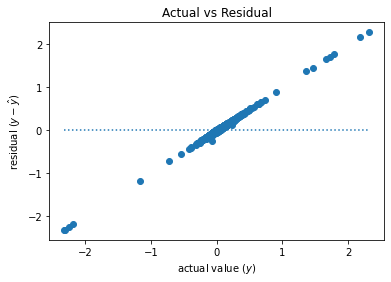

,sse,ess,tss,mse,rmse,r^2
0,68.483519,0.269553,68.753072,0.021475,0.146543,0.003921


In [59]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidcity',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_landtaxvaluedollarcnt']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidcity',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_landtaxvaluedollarcnt']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_pred_mean'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
pd.DataFrame(evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)).T

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model performs about the same as the baseline model.</div>

###  <font color=blue> Out of Sample Performance Linear Regression Model (Ventura County)</font>

In [60]:
X_validate_scaled = X[1][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

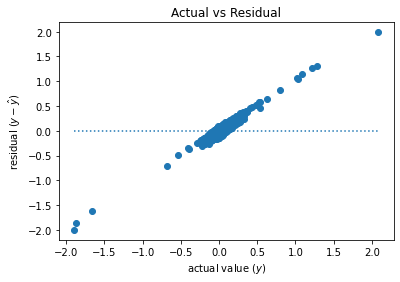

,sse,ess,tss,mse,rmse,r^2
0,35.608546,4.409646,30.988685,0.026049,0.161396,0.142299


In [61]:
# predict validate
y_validate['yhat_lm'] = lm.predict(X_validate_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.logerror, y_validate.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on out-of-sample data
vc_lm_eval = pd.DataFrame(evaluate.regression_errors(y_validate.logerror, y_validate.yhat_lm)).T
vc_lm_eval

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model performs worse on out-of-sample data than the baseline model. It does perform slightly better than the LM model that does not control for county.</div>

###  <font color=orange> Orange County Properties </font>

In [62]:
#Create Orange County df
df_orange = df[df.Orange == 1].drop(columns = ['LA', 'Ventura', 'Orange']) 

#Split the Data
partitions = explore.split(df_orange, target_var='logerror')
train = partitions[0]
partitions[0] = train

# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)
for i in range(len(X)):
    X[i] = scale_and_concat(X[i])
    
#Define the other dataframes from partitions
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

In [63]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train_scaled, y_train)

#Return top 5 features

f_support = f_selector.get_support()
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
print(f'Select KBest returned the top 5 features for predicting logerror for ORANGE COUNTY as: {f_feature}')

Select KBest returned the top 5 features for predicting logerror for ORANGE COUNTY as: ['scaled_bathroomcnt', 'scaled_bedroomcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_structuretaxvaluedollarcnt', 'scaled_acres']


### <font color=orange> Baseline Model (Orange County) </font>

In [64]:
# 1. Predict logerror_pred_mean
yhat_pred_mean = y_train['logerror'].mean()
y_train['yhat_pred_mean'] = yhat_pred_mean

#Evaluate the baseline model using the mean
oc_baseline_stats = pd.DataFrame([evaluate.baseline_mean_errors(y_train.logerror)])
oc_baseline_stats

,sse,mse,rmse
0,360.787998,0.032471,0.180198


### <font color=orange> Linear Regression Model (Orange County) </font>

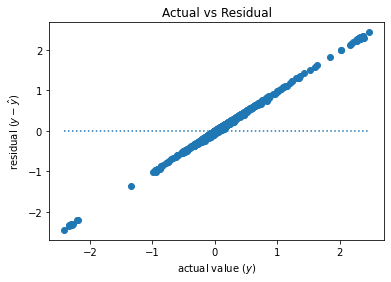

,sse,ess,tss,mse,rmse,r^2
0,359.610048,1.17795,360.787998,0.032365,0.179903,0.003265


In [65]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidcity',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_landtaxvaluedollarcnt']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidcity',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_landtaxvaluedollarcnt']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_pred_mean'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
pd.DataFrame(evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)).T

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model performs about the same as the baseline model.</div>

### <font color=orange> Out of Sample Performance Linear Regression Model (Orange County) </font>

In [66]:
X_validate_scaled = X[1][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

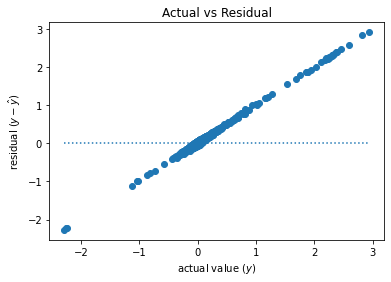

,sse,ess,tss,mse,rmse,r^2
0,195.205122,8.384573,189.057247,0.040992,0.202465,0.044349


In [67]:
# predict validate
y_validate['yhat_lm'] = lm.predict(X_validate_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip',
 'scaled_taxrate']])

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.logerror, y_validate.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on out-of-sample data
oc_lm_eval = pd.DataFrame(evaluate.regression_errors(y_validate.logerror, y_validate.yhat_lm)).T
oc_lm_eval

<div class="alert alert-block alert-info"><b>Takeaway:</b> The linear regression model performs worse than the baseline model on out of sample data. It also performs worse than the lm model not controlling for county.</div>

### Overall Modeling Evaluations

In [68]:
#Create a dataframe with all the model evaluation metrics
model_names = ['all_counties', 'los_angeles', 'ventura', 'orange']
modeling_evaluations = pd.concat([ac_lm_eval, la_lm_eval, vc_lm_eval, oc_lm_eval]).set_index([model_names])
modeling_evaluations

,sse,ess,tss,mse,rmse,r^2
all_counties,457.256636,12.404901,445.405400,0.027489,0.165799,0.027851
los_angeles,272.846257,0.643601,273.290654,0.025973,0.161161,0.002355
ventura,35.608546,4.409646,30.988685,0.026049,0.161396,0.142299
orange,195.205122,8.384573,189.057247,0.040992,0.202465,0.044349


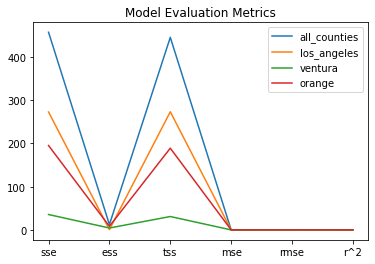

In [69]:
#Plot the evaluation metrics for each linear regression model
modeling_evaluations.T.plot()
plt.title('Model Evaluation Metrics')
plt.show()

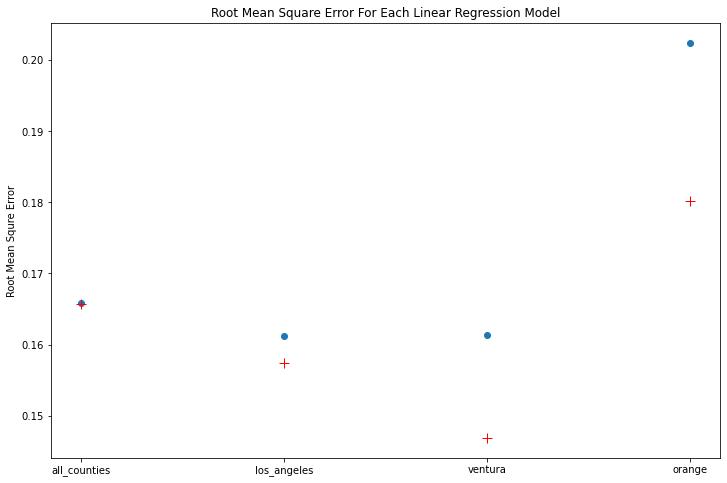

In [70]:
#Plot the RMSE for each model and corresponding baseline rmse
plt.figure(figsize=(12,8))
plt.plot(modeling_evaluations.rmse, 'o')
plt.plot(modeling_evaluations.index[0], all_county_baseline_stats.rmse, 'r+', markersize=10)
plt.plot(modeling_evaluations.index[1], la_baseline_stats.rmse, 'r+', markersize=10)
plt.plot(modeling_evaluations.index[2], vc_baseline_stats.rmse, 'r+', markersize=10)
plt.plot(modeling_evaluations.index[3], oc_baseline_stats.rmse, 'r+', markersize=10)
plt.title('Root Mean Square Error For Each Linear Regression Model')
plt.ylabel('Root Mean Squre Error')

plt.show()

---

# Conclusions & Next Steps

> - Logerror is statistically greater for properties in LA County than properties in Ventura/Orange Counties.
     - We have built three separate models (one for each county) to see if by controlling for county we can better predict logrror.

> - Logerror is statistically different for properties with >5 acres than properties with <5 acres.
    - However, Select KBest does not return acres as of of the top 5 features for predicting logerror

> - Clustering By Acres and Living Square Footage produces 4 clusters that may help with modeling in future iterations:
    - Rural Homes, Suburban Homes, Small City Homes, Large City Homes/Condos
    
> - Modeling to predict logerror needs additional work and analysis.<br>
    - We build 4 linear Regression Models, all of which only did marginally better than baseline or performed slightly worse than baseline.
    
> - Individual models controlling for Ventura County and Los Angeles County respectively did perform better in comparison to the all county linear regression model.
    - Orange county linear regression model performed worse than its' corresponding baseline model and in comparison to the all county linear regression model.
    
> - There are many next steps that can be taken:
    - Utilize clustering observations as features for predicting logerror
    - Utilize other ML algorithms that may perform better than the linear regression model
    - Tweak hyperparameters while continuing to control for county